# Poisson equation in 1D

In this tutorial, we show how to solve the Poisson equation in 1D

$$ - \frac{\partial^2 u}{\partial^2 x} = f(x)  \quad \forall x \in (0,1), $$

using different types of boundary conditions.

## Homogeneus Dirichlet boundary conditions

Consider

$$ - \frac{\partial^2 u}{\partial^2 x} = f(x)  \quad \forall x \in (0,1), $$
with homegeneuos Dirichlet boundary conditions $u(0) = u(1) = 0$.

To obtain the weak form, we let $\Omega = (0,1)$ and we define the functional space $V = H^1_0(\Omega)$.
Then we multiply the strong form by an arbitrary function $v \in V$ and integrate over $\Omega$:

$$ - \int_0^1 \frac{\partial^2 u}{\partial^2 x} v \, dx = \int_0^1 f\,v \, dx, \quad \forall v \in V $$

Integration by parts of the non-conforming term gives

$$ - \int_0^1 \frac{\partial^2 u}{\partial^2 x} v \, dx = \int_0^1 \frac{\partial u}{\partial x} \frac{\partial v}{\partial x} \, dx - \left( \left.\frac{\partial u}{\partial x}\right|_{x=1}\, v(1) - \left.\frac{\partial u}{\partial x}\right|_{x=0}\,v(0) \right). $$

Recalling that $v(1) = v(0) = 0$ because of the Dirichlet boundary conditions, we finally write

$$ \int_0^1 \frac{\partial u}{\partial x} \frac{\partial v}{\partial x} \, dx = \int_0^1 f\,v \, dx, \quad \forall v \in V. $$

To obtain the finite element discretization we then consider a finite dimensional subspace $V_h \subset V$ and we find $u_h \in V_h$ such that

$$ \int_0^1 \frac{\partial u_h}{\partial x} \frac{\partial v_h}{\partial x} \, dx = \int_0^1 f\,v_h \, dx, \quad \forall v_h \in V_h. $$

Below we solve the problem using FEniCS for the choice $f(x) = \sin(\pi x)$. The analytical solution is $u_{ex} = \frac{1}{\pi^2} \sin(\pi x)$.

### 1. Imports
We import the following Python packages:

- `dolfin` is the python interface to FEniCS.
- `matplotlib` is a plotting library that produces figure similar to the Matlab ones.
- `math` is the python built-in library of mathematical functions.

In [1]:
from __future__ import print_function
# Import FEniCS
from dolfin import *
# Enable plotting inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline
# Import the package of mathematical functions
import math

### 2. Define the mesh and the finite element space
We define a mesh of the domain $(0,1)$ with `n` elements and `n+1` vertices. The mesh size $h$ is $\frac{1}{n}$.
`UnitIntervalMesh` is a dolfin class that create a mesh for the unit interval. It takes as input the number of elements $n$.

We also define the finite element space $V_h$ as the space of globally continuos functions that are piecewise linear  on the elements of the mesh. The number of degrees of freedom (dofs) of the space $V_h$ is $n+1$ (i.e. equal to the number of vertices in the mesh).
`FunctionSpace` is a dolfin class that constructs the finite element space. It takes as inputs the mesh, the type of finite element (`CG` stands for *Continuous Galerkin* elements), and the finite element order (in our case $1$, since we are using linear finite element).

Number of dofs 21


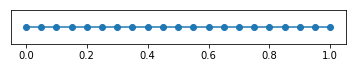

In [2]:
# Define the finite element mesh. The mesh size h is 1/n
n = 20
mesh = UnitIntervalMesh(n)

plot(mesh)

# Define the finite element space V_h as the space of piecewise linear functions on the elements of the mesh.
Vh = FunctionSpace(mesh, 'CG', 1)
print ("Number of dofs", Vh.dim())

### 3. Define the right hand side f
We define the right hand side of the PDE using the dolfin class `Expression`. This class takes as input a string that define the analytical form of the expression and the polynomial degree `degree` of the expression (if the expression is not a polynomial it will be interpolated). Here `x[0]` denotes the x coordinate of the mesh. In 2D, `x[1]` denotes the y coordinate of the mesh. Additional parameters can be passed to the expression. In this case we define the frequency $\omega = \pi$ as a parameter for the expression.

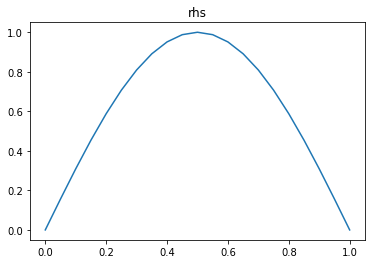

In [3]:
# Define the right hand side. "x[0]" denotes the space coordinate x.
f = Expression("sin(omega*x[0])", omega = pi, degree = 5)

#visualize the rhs:
plot(f,mesh=mesh, title="rhs")

### 4. Define the Dirichlet boundary condition
We define the Dirichlet boundary condition on the $u(0) = u(1) = 0$.
The class `Constant` is similar `Expression` and it is used when we need to represent a value that is *constant* in space. As input it takes the value of the constant.
`DirichletBC` is the dolfin class that is used to describe Dirichlet boundary conditions. It takes three inputs: the finite element space $V_h$, the expression/value of the Dirichlet boundary condition `u_bc`, and finally a *function* that returns true if the point `x` belongs to a portion of the Dirichlet boundary.

In [4]:
u_bc = Constant(0.)
def dirichlet_boundary(x,on_boundary):
    return on_boundary
bcs = [DirichletBC(Vh, u_bc, dirichlet_boundary)]

### 5. Define the weak form
We now write the weak form of the Poisson equation:

- `uh`, the *trial* function, is an instance of the dolfin class `TrialFunction`
- `vh`, the *test* function, is an instance of the dolfin class `TestFunction`
- `grad` is the gradient operator acting on either a trial or test function. (In 1D $\operatorname{grad} := \frac{d}{dx}$).
- `inner` is the product of two scalar, vector, or tensor functions
- `dx` denotes that the integration is performed on the whole domain. `ds` (see next example) denotes that the integration is on the boundary of the domain.

**Note**: the `TrialFunction` and `TestFunction` are special objects used by FEniCS to represent a weak form. `uh` does **not** contains the vector of interpolation weights of the solution.


In [5]:
# Define the trial function u and the test function v
uh = TrialFunction(Vh)
vh = TestFunction(Vh)

# Define the weak form for the stiffness matrix (A_form) and for the rhs (b_form):
A_form = inner(grad(uh), grad(vh))*dx
b_form = inner(f,vh)*dx

### 6. Assemble and solve the finite element discrete problem
We now assemble the finite element stiffness matrix $A$ and the right hand side vector $b$ using the dolfin method `assemble_system`. `assemble_system` takes the following inputs: the bilinear form `A_form`, the linear form `b_form`, and a list of Dirichlet boundary conditions `bcs`. This method will automatically generate and compile efficient c++ code to perform the local assembly on each element of the mesh, and it returns the assembled global matrices after applying the Dirichlet boundary conditions.

We now define the finite element function `uh = Function(Vh)` that represents the solution of the PDE. The interpolation weights are stored in `uh.vector()`. We use the `solve(A,u,b)` command to solve the linear system $Au = b$.

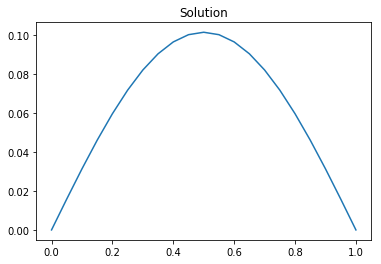

In [6]:
# Assemble the stiffness matrix A and rhs b. Apply the boundary conditions
A, b = assemble_system(A_form, b_form, bcs)

# Solve the linear system and visualize the solution
uh = Function(Vh)
solve(A, uh.vector(), b)
plt.figure()
plot(uh, title = "Solution")

### 7. Compute error norms
We then compute the $L^2(\Omega)$ and energy norm of the error.
We use the dolfin function `assemble` to integrate $|u_h - u_{ex}|^2$ and $\left|\frac{d u_h}{dx} - \frac{d u_{ex}}{dx}\right|^2$
in the domain $\Omega$.

In [7]:
# Compute the L^2 norm of the error
u_ex = Expression("(1./(omega*omega))*sin(omega*x[0])", omega = pi, degree = 5)
err_L2 = math.sqrt( assemble((uh-u_ex)**2*dx) ) 

print ("|| u_h - u_ex ||_L^2 = {0:5e}".format(err_L2))

# Compute the energy norm of the error
grad_u_ex = Expression( "(1./(omega))*cos(omega*x[0])" , omega = pi, degree = 5)
err_energy = math.sqrt( assemble((grad(uh)[0]-grad_u_ex)**2*dx) )

print ("|| u_h - u_ex ||_e = {0:5e}".format(err_energy))

|| u_h - u_ex ||_L^2 = 1.612874e-04
|| u_h - u_ex ||_e = 1.020201e-02


## Mixed Dirichlet and Neumann boundary conditions

Consider

$$ - \frac{\partial^2 u}{\partial^2 x} = f(x) \quad \forall x \in (0,1), $$
with boundary conditions:
$$
u(0) = 0, \quad \left.\frac{\partial u}{\partial x}\right|_{x=1} = g
$$

To obtain the weak form, we let $\Omega = (0,1)$ and we define the functional space
$V = \left\{ v \in H^1(\Omega) | v(0) = 0 \right\}$.
Then we multiply the strong form by an arbitrary function $v \in V$ and integrate over $\Omega$:

$$ - \int_0^1 \frac{\partial^2 u}{\partial^2 x} v \, dx = \int_0^1 f\,v \, dx, \quad \forall v \in V $$

Integration by parts of the non-conforming term gives

$$ - \int_0^1 \frac{\partial^2 u}{\partial^2 x} v \, dx = \int_0^1 \frac{\partial u}{\partial x} \frac{\partial v}{\partial x} \, dx - \left( \left.\frac{\partial u}{\partial x}\right|_{x=1}\, v(1) - \left.\frac{\partial u}{\partial x}\right|_{x=0}\,v(0) \right). $$

Recalling that $v(0) = 0$ and $\left.\frac{\partial u}{\partial x}\right|_{x=1} = g$ because of the boundary conditions, we finally write

$$ \int_0^1 \frac{\partial u}{\partial x} \frac{\partial v}{\partial x} \, dx = g\,v(1) + \int_0^1 f\,v \, dx, \quad \forall v \in V. $$

To obtain the finite element discretization we then consider a finite dimensional subspace $V_h \subset V$ and we find $u_h \in V_h$ such that

$$ \int_0^1 \frac{\partial u_h}{\partial x} \frac{\partial v_h}{\partial x} \, dx = g\,v(1) + \int_0^1 f\,v_h \, dx, \quad \forall v_h \in V_h. $$

Below we solve the problem using FEniCS for the choice $f(x) = 2$, $g = -1$. The analytical solution is $u_{ex} = x - x^2$

Number of dofs 21
|| u_h - u_ex ||_L^2 = 4.564355e-04
|| u_h - u_ex ||_e = 2.886751e-02


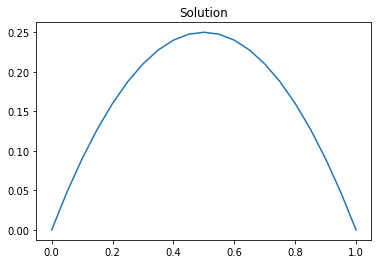

In [8]:
#1. Imports
from dolfin import *
import matplotlib.pyplot as plt
%matplotlib inline
import math

#2. Define the mesh and the finite element space
n = 20
mesh = UnitIntervalMesh(n)
Vh = FunctionSpace(mesh, 'CG', 1)
print ("Number of dofs", Vh.dim())

#3. Define the right hand side f and the non-homogeneus Neumann condition g
f = Constant(2.)
g = Constant(-1.)

#4. Define the Dirichlet boundary condition
u_bc = Constant(0.)
def dirichlet_boundary(x,on_boundary):
    return on_boundary and near(x[0], 0)
bcs = [DirichletBC(Vh, u_bc, dirichlet_boundary)]

#5. Define the weak form
uh = TrialFunction(Vh)
vh = TestFunction(Vh)

A_form = inner(grad(uh), grad(vh))*dx
b_form = inner(Constant(-1.), vh)*ds + inner(f,vh)*dx  

#6. Assemble and solve the finite element discrete problem
A, b = assemble_system(A_form, b_form, bcs)
uh = Function(Vh)
solve(A, uh.vector(), b)
plt.figure()
plot(uh, title = "Solution")

#7. Compute error norms
u_ex = Expression("x[0] - x[0]*x[0]", degree = 2)
err_L2 = math.sqrt( assemble((uh-u_ex)**2*dx) ) 
print ("|| u_h - u_ex ||_L^2 = {0:5e}".format(err_L2))

grad_u_ex = Expression("1. - 2.*x[0]", degree = 1)
err_energy =math.sqrt( assemble((grad(uh)[0]-grad_u_ex)**2*dx) )
print ("|| u_h - u_ex ||_e = {0:5e}".format(err_energy))